In [1]:
import torch
from transformers import BertModel, BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

In [2]:
# 设置device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载预训练模型
pretrained = BertModel.from_pretrained('model/bert-base-chinese/')
# 需要移动到cuda上
pretrained.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [3]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 冻结预训练模型的所有参数
        for param in pretrained.parameters():
            param.requires_grad = False
        self.fc1 = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # 预训练好的模型不需要训练，但是它的输出需要梯度
        output = pretrained(input_ids, attention_mask, token_type_ids)
        # 取出[CLS]的输出
        output = output.last_hidden_state[:, 0, :]
        output = self.fc1(output)
        return output

In [4]:
model = Model()
# 同样要移动到cuda
model.to(device)

Model(
  (fc1): Linear(in_features=768, out_features=5, bias=True)
)

In [5]:
# 后面的计算和中文分类完全一样，只是放在了cuda上计算
# 定义数据集
class Dataset(torch.utils.data.Dataset):

    def __init__(self, split):
        self.dataset = load_dataset('resampled_datasets')[split]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        text = self.dataset[i]['text']
        label = self.dataset[i]['label']
        return text, label

In [6]:
dataset = Dataset('train')

# 加载字典和分词工具
token = BertTokenizer.from_pretrained('./model/')

In [7]:
def collate_fn(data):
    sents = [i[0] for i in data]
    labels = [i[1] for i in data]

    # 编码
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,
                                   padding='max_length',
                                   max_length=200,
                                   return_tensors='pt',
                                   return_length=True)
    # input_ids:编码之后的数字
    # attention_mask:是补零的位置是0,其他位置是1
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    token_type_ids = data['token_type_ids'].to(device)
    labels = torch.LongTensor(labels).to(device)
    #print(data['length'], data['length'].max())
    return input_ids, attention_mask, token_type_ids, labels

In [8]:
# 数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=128,
                                     collate_fn=collate_fn,
                                     shuffle=True,
                                     drop_last=True)

In [9]:
# 验证
def val(criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    loader_test = torch.utils.data.DataLoader(dataset=Dataset('validation'),
                                              batch_size=32,
                                              collate_fn=collate_fn,
                                              shuffle=True,
                                              drop_last=True)
    for i, (input_ids, attention_mask, token_type_ids,
            labels) in enumerate(loader_test):
        with torch.no_grad():
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)
        new_labels = labels - 1
        loss = criterion(out, new_labels)
        val_loss += loss.item()
        correct += (out.argmax(dim=1) == new_labels).sum().item()
        total += len(labels)
    model.train()
    return correct / total, val_loss / len(loader_test)

In [10]:
# 训练
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()
model.train()

num_epochs = 10
train_loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(loader):
        out = model(input_ids=input_ids, attention_mask=attention_mask,
                    token_type_ids=token_type_ids)
        new_labels = labels - 1
        loss = criterion(out, new_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 3 == 0:
            acc, val_loss = val(criterion)
            print(
                f"strp = {i+1}, train_loss = {loss.item()}, val_loss = {val_loss}, val_acc = {acc}")
            train_loss_list.append(loss.item())
            val_loss_list.append(val_loss)
            val_acc_list.append(acc)

Epoch 1/10
strp = 1, train_loss = 1.7467377185821533, val_loss = 1.6510363050869532, val_acc = 0.21205357142857142
strp = 4, train_loss = 1.5617016553878784, val_loss = 1.5897682479449682, val_acc = 0.27232142857142855
strp = 7, train_loss = 1.4807062149047852, val_loss = 1.5180290256227766, val_acc = 0.3482142857142857
strp = 10, train_loss = 1.4118927717208862, val_loss = 1.453406810760498, val_acc = 0.37723214285714285
strp = 13, train_loss = 1.336926817893982, val_loss = 1.4030994517462594, val_acc = 0.421875
Epoch 2/10
strp = 1, train_loss = 1.3299990892410278, val_loss = 1.3729339923177446, val_acc = 0.4486607142857143
strp = 4, train_loss = 1.265798568725586, val_loss = 1.3542605127607072, val_acc = 0.48660714285714285
strp = 7, train_loss = 1.2043406963348389, val_loss = 1.3124962108475822, val_acc = 0.4799107142857143
strp = 10, train_loss = 1.1220433712005615, val_loss = 1.28382636819567, val_acc = 0.45535714285714285
strp = 13, train_loss = 1.1596543788909912, val_loss = 1.2

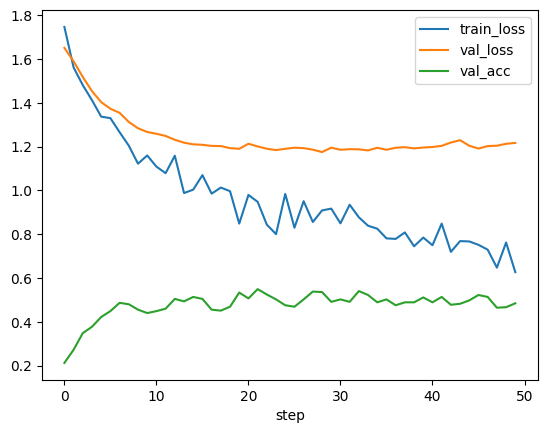

In [11]:
# 绘制图像
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.plot(val_acc_list, label='val_acc')
plt.xlabel('step')
# plt.ylim(0, 1.6)
plt.legend()
plt.show()

In [12]:
# 保存模型
torch.save(model.state_dict(), 'model.pth')